In [1]:
#importing important packages and libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import os

'''the data used in this model can be found here
https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data'''

In [2]:
!unzip -q /content/training_solutions_rev1.zip

In [3]:
df = pd.read_csv('/content/training_solutions_rev1.csv')

In [4]:
df_train, df_test = train_test_split(df, test_size=.2)
df_train.shape, df_test.shape

((49262, 38), (12316, 38))

In [5]:
#performing EDA
df_train.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
55398,909408,0.419668,0.525434,0.054898,0.000000,0.525434,0.000000,0.525434,0.240748,0.284686,...,0.000000,0.000000,0.240748,0.000000,0.0,0.000000,0.0,0.0,0.080169,0.160579
32081,570806,0.218758,0.781242,0.000000,0.781242,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.138254,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
26660,489626,0.020079,0.979921,0.000000,0.065650,0.914271,0.467947,0.446324,0.695957,0.218314,...,0.043788,0.041045,0.131198,0.523714,0.0,0.695957,0.0,0.0,0.000000,0.000000
59889,974831,0.590911,0.404750,0.004339,0.000000,0.404750,0.000000,0.404750,0.000000,0.404750,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
53317,877768,0.503708,0.485687,0.010606,0.138085,0.347602,0.000000,0.347602,0.000000,0.347602,...,0.138085,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
32163,571848,0.774656,0.193869,0.031474,0.000000,0.193869,0.000000,0.193869,0.000000,0.193869,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
10243,252083,0.072795,0.927205,0.000000,0.076480,0.850725,0.122572,0.728154,0.484758,0.365968,...,0.000000,0.314713,0.150452,0.019592,0.0,0.484758,0.0,0.0,0.000000,0.000000
59159,964149,0.198395,0.792967,0.008638,0.040313,0.752654,0.123139,0.629515,0.066769,0.685885,...,0.000000,0.000000,0.066769,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.066769
29416,531141,0.582258,0.393924,0.023817,0.000000,0.393924,0.000000,0.393924,0.000000,0.393924,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
20146,395080,0.861000,0.139000,0.000000,0.000000,0.139000,0.000000,0.139000,0.083400,0.055600,...,0.000000,0.027772,0.000000,0.055628,0.0,0.000000,0.0,0.0,0.027772,0.055628


In [6]:
!unzip -q /content/images_training_rev1.zip

In [8]:
trainPath = '/content/images_training_rev1'

In [9]:
import random
#creating a function to plot galaxies from the dataset randomly
def plot_random_galaxy(path, sample=5):
    random_image = random.sample(os.listdir(path), sample)

    plt.figure(figsize=(16,5))
    for i in range(sample):
        plt.subplot(1,sample,i+1)

        img_path = os.path.join(path, random_image[i])
        img = Image.open(img_path)  # Using Pillow to open image

        # Converting PIL Image to numpy array
        img_array = np.array(img)

        plt.imshow(img_array)
        plt.title(f'Class: {random_image[i]}\nShape: {img_array.shape}')
        plt.axis(False)

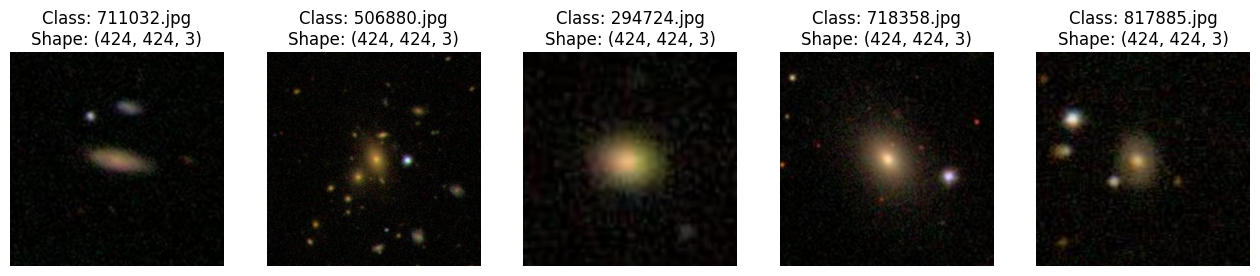

In [10]:
plot_random_galaxy(trainPath)

In [11]:
import torch
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

#creating function to crop and resize images

def get_image(path, x1, y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    # Converting to PyTorch tensor and add channel dimension if needed
    x = torch.from_numpy(x).float()
    # If grayscale, add channel dimension
    if x.ndim == 2:
        x = x.unsqueeze(0)
    # If RGB, transpose to ensure channel-first format
    elif x.ndim == 3 and x.shape[2] in [3, 4]:
        x = x.permute(2, 0, 1)
    return x

#getting all the images from the dataset and converting them to pytorch tensors for data analysis

def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2

    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]

    x_batch = []
    for i in tqdm(ids):
        x = get_image('/content/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)

    # Converting list of tensors to a single tensor
    x_batch = torch.stack(x_batch)

    # Convert labels to tensor
    y_batch = torch.tensor(y_batch).float()

    return x_batch, y_batch

In [12]:
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████| 12316/12316 [01:28<00:00, 139.68it/s]


In [13]:
X_train.shape

torch.Size([49262, 3, 64, 64])

In [14]:
X_train[0]

tensor([[[6.9015e-05, 7.2956e-05, 5.7490e-05,  ..., 1.2496e-04,
          1.1292e-04, 7.3713e-05],
         [4.7933e-05, 1.2247e-04, 7.4060e-05,  ..., 1.0156e-04,
          1.6772e-04, 8.5680e-05],
         [4.8751e-05, 1.0105e-04, 7.2358e-05,  ..., 7.6385e-05,
          9.3528e-05, 1.4710e-04],
         ...,
         [6.1333e-05, 2.7273e-05, 3.1521e-05,  ..., 7.0962e-05,
          1.3443e-04, 3.5206e-05],
         [9.9896e-05, 4.9273e-05, 8.7092e-05,  ..., 4.2754e-05,
          5.4521e-05, 2.2071e-05],
         [9.6294e-05, 8.6320e-05, 8.2239e-05,  ..., 6.4765e-05,
          4.9997e-05, 3.5413e-05]],

        [[5.3636e-05, 5.7578e-05, 4.2112e-05,  ..., 1.0958e-04,
          9.7545e-05, 5.8334e-05],
         [3.2552e-05, 1.0708e-04, 5.8679e-05,  ..., 8.6180e-05,
          1.5235e-04, 7.0302e-05],
         [2.8787e-05, 8.1091e-05, 5.3030e-05,  ..., 6.1006e-05,
          7.8149e-05, 1.3172e-04],
         ...,
         [6.1333e-05, 2.7273e-05, 3.1521e-05,  ..., 7.0962e-05,
          1.344

In [15]:
y_train.shape

torch.Size([49262, 37])

In [16]:
#there are 49262 images and there are 37 different labels
y_train[0]

tensor([0.4197, 0.5254, 0.0549, 0.0000, 0.5254, 0.0000, 0.5254, 0.2407, 0.2847,
        0.1589, 0.3141, 0.0524, 0.0000, 0.6821, 0.3179, 0.0000, 0.3323, 0.0873,
        0.0000, 0.0000, 0.0648, 0.3574, 0.1623, 0.0975, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2407, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0802,
        0.1606])

In [17]:
#now we will build the model for classification
class Morphology_Predictor(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=512, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=512,
                  out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AdaptiveMaxPool2d(1)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(128, 128),
        nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(128, 128),
        nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(128, 128),
        nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(in_features=128, out_features=37),
        nn.Sigmoid()

    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.conv_block_3(x)
    #print(x.shape)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)

    #print(x.shape)
    return x

In [18]:
#device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
#creating a model instance on the GPU
model_1 = Morphology_Predictor(input_shape=3, output_shape=37).to(device)

In [20]:
model_1

Morphology_Predictor(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, mom

In [29]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adamax(params=model_1.parameters(),
                            lr=0.001)

In [30]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
from torch.utils.data import DataLoader
#setting up the batch size hyperparameter
BATCH_SIZE = 128
#turning datasets into iterables(batches)
train_dataloader = DataLoader(
    dataset= list(zip(X_train,y_train)),
    batch_size=BATCH_SIZE,
    shuffle=True

)

test_dataloader = DataLoader(
    dataset= list(zip(X_test,y_test)),
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c6cf23ba7d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c6cf23ba500>)

In [33]:
#creating a function to time our experiments
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end- start
  print(f'Train time on {device}: {total_time:.3f} seconds')
  return total_time


def multi_label_accuracy(predictions, labels, threshold=0.5):
    """
    Returns:
    - Accuracy as a float
    """
    # Convert predictions and labels to binary using threshold
    binary_predictions = (predictions >= threshold).float()
    binary_labels = (labels >= threshold).float()

    # Calculate true positives, true negatives, false positives, false negatives
    true_positives = torch.sum((binary_predictions == 1) & (binary_labels == 1)).float()
    true_negatives = torch.sum((binary_predictions == 0) & (binary_labels == 0)).float()
    false_positives = torch.sum((binary_predictions == 1) & (binary_labels == 0)).float()
    false_negatives = torch.sum((binary_predictions == 0) & (binary_labels == 1)).float()

    # Calculate accuracy
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    return accuracy.item()

#we need a measure of accuracy for our data where the probabilities are not converted to binary values but are evaluated using proximity of the individual predicted and actual probabilities
def multi_label_mse(predictions, labels):
    """
    Returns:
    - MSE as a float (lower is better)
    """
    return torch.mean((predictions - labels)**2).item()


In [35]:
from tqdm.auto import tqdm

#setting the seed and starting the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n--------')
  ###training
  train_loss = 0 #coz we are evaluating the model batchwise so we need a variable for overall loss
  train_mse = 0 #initializing mean squared error
  for batch, (x, y) in enumerate(train_dataloader):
    model_1.train()
    #x, y = x.to(device), y.to(device) #already did this while loading the data in the dataloader
    y_pred = model_1(x)
    loss = loss_fn(y_pred, y)
    mse = multi_label_mse(y_pred, y)
    train_loss += loss
    train_mse += mse
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 50 == 0:
      print(f'looked at {batch * len(x)}/{len(train_dataloader.dataset)} samples')

  train_loss /= len(train_dataloader)
  train_mse /= len(train_dataloader)

  test_loss, test_acc, test_mse = 0,0,0
  model_1.eval()
  with torch.inference_mode():
    for x_test, y_test in test_dataloader:
      #x_test, y_test = x_test.to(device), y_test.to(device)
      test_pred = model_1(x_test)
      test_loss += loss_fn(test_pred, y_test)
      test_mse += multi_label_mse(test_pred, y_test)
      test_acc += multi_label_accuracy(test_pred, y_test)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_mse /= len(test_dataloader)

  print(f'Train loss: {train_loss:.5f}, training MSE: {train_mse:.4f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}, test MSE: {test_mse:.4f}')

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                             end=train_time_end_on_cpu,
                                             device=str(next(model_1.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
looked at 0/49262 samples
looked at 6400/49262 samples
looked at 12800/49262 samples
looked at 19200/49262 samples
looked at 25600/49262 samples
looked at 32000/49262 samples
looked at 38400/49262 samples
looked at 44800/49262 samples
Train loss: 0.28798, training MSE: 0.0233, test loss: 0.29318, test acc: 0.91409, test MSE: 0.0300
Epoch: 1
--------
looked at 0/49262 samples
looked at 6400/49262 samples
looked at 12800/49262 samples
looked at 19200/49262 samples
looked at 25600/49262 samples
looked at 32000/49262 samples
looked at 38400/49262 samples
looked at 44800/49262 samples
Train loss: 0.28705, training MSE: 0.0231, test loss: 0.29113, test acc: 0.91795, test MSE: 0.0294
Epoch: 2
--------
looked at 0/49262 samples
looked at 6400/49262 samples
looked at 12800/49262 samples
looked at 19200/49262 samples
looked at 25600/49262 samples
looked at 32000/49262 samples
looked at 38400/49262 samples
looked at 44800/49262 samples
Train loss: 0.28565, training MSE: 0.0227, 